In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST digits (28x28 grayscale images)
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # shape (60000, 28, 28, 1)

print("Training data shape:", x_train.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training data shape: (60000, 28, 28, 1)


**Generator takes random noise (100 numbers) → produces fake digit image (28x28).**

In [4]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 256)),

        layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='sigmoid')
    ])
    return model

generator = build_generator()
generator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

**Discriminator takes image (real/fake) → outputs real/fake probability.**

In [5]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Binary cross-entropy loss (for real vs fake classification)
cross_entropy = tf.keras.losses.BinaryCrossentropy()

# Optimizers for both Generator & Discriminator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


# One training step: update Generator & Discriminator
@tf.function
def train_step(images):
    # 1. Sample random noise (latent vector) to feed the generator
    noise = tf.random.normal([BATCH_SIZE, 100])

    # 2. Record operations for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # --------------------
        # Forward pass
        # --------------------

        # Generator creates fake images from random noise
        generated_images = generator(noise, training=True)

        # Discriminator evaluates real images (should predict 1 / real)
        real_output = discriminator(images, training=True)

        # Discriminator evaluates fake images (should predict 0 / fake)
        fake_output = discriminator(generated_images, training=True)


        # --------------------
        # Loss functions
        # --------------------

        # Generator wants Discriminator to believe fake images are real (label = 1)
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

        # Discriminator tries to classify correctly:
        # - real images as 1
        # - fake images as 0
        disc_loss = (
            cross_entropy(tf.ones_like(real_output), real_output) +  # real -> 1
            cross_entropy(tf.zeros_like(fake_output), fake_output)   # fake -> 0
        )


    # --------------------
    # Compute gradients
    # --------------------

    # Gradient of Generator loss wrt Generator weights
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    # Gradient of Discriminator loss wrt Discriminator weights
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)


    # --------------------
    # Apply gradients (update weights)
    # --------------------

    # Update Generator weights to fool Discriminator better
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )

    # Update Discriminator weights to distinguish better
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )


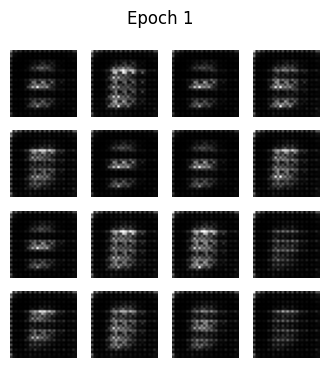

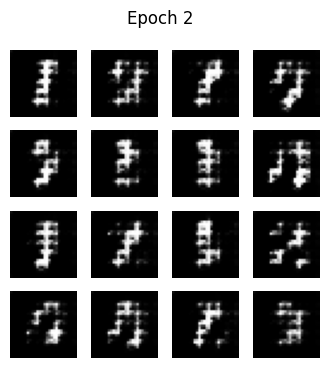

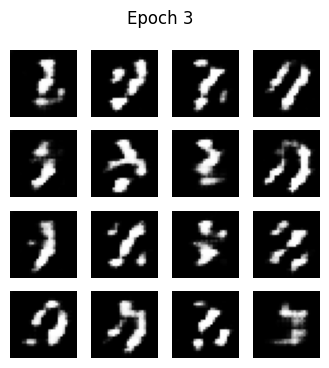

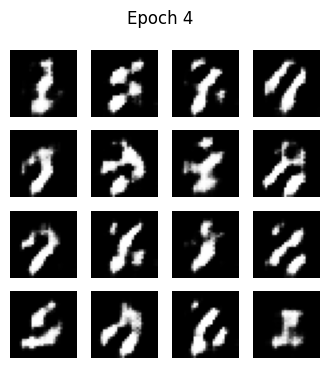

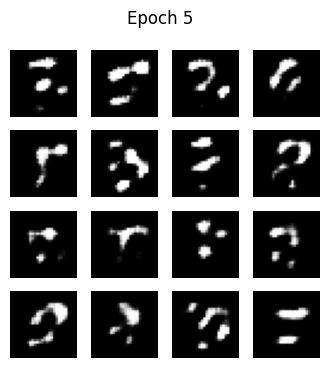

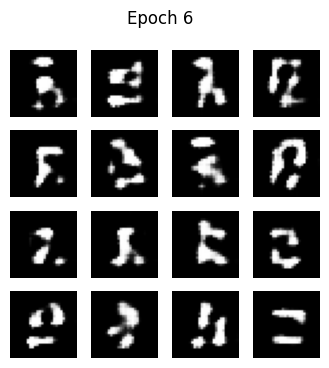

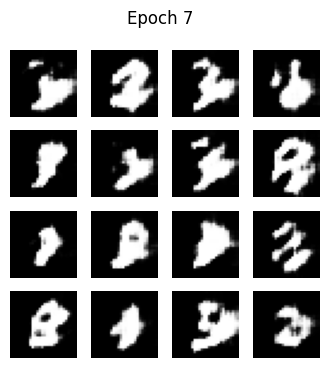

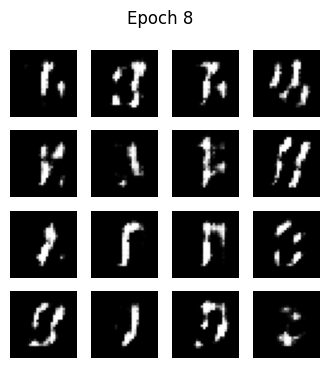

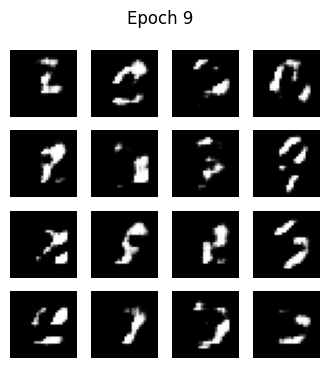

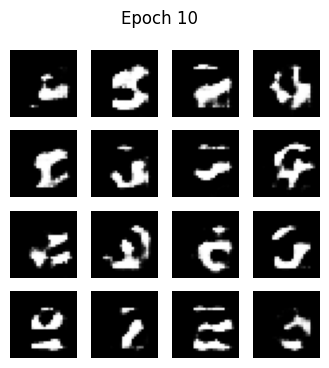

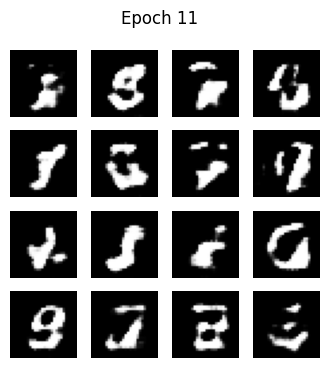

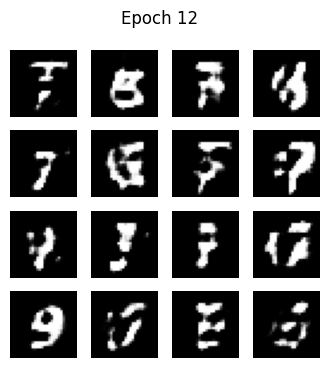

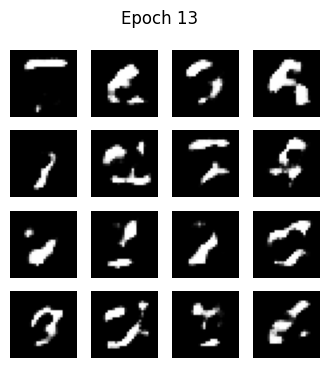

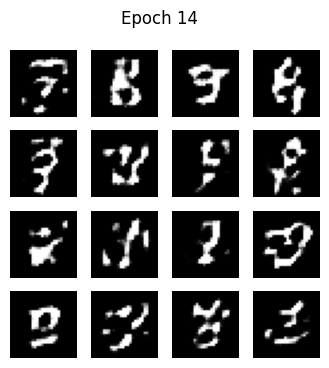

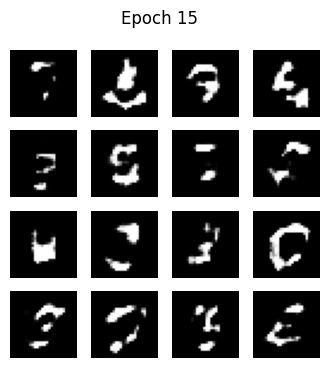

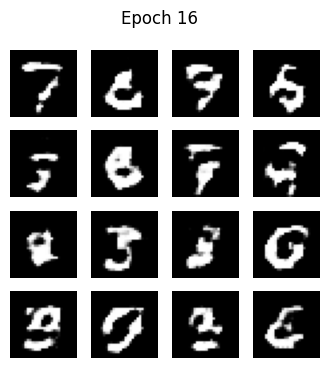

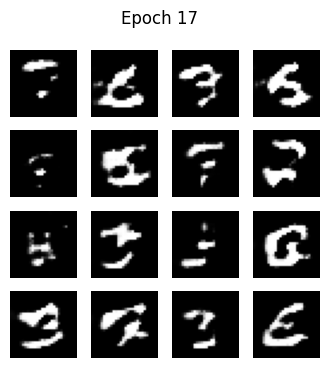

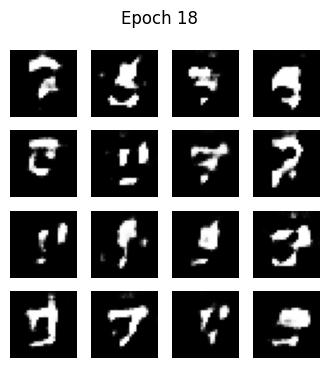

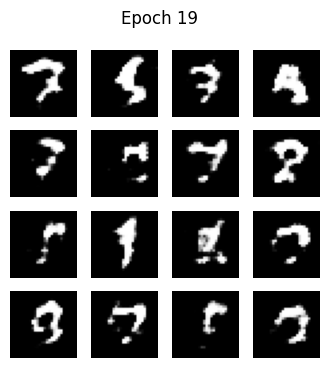

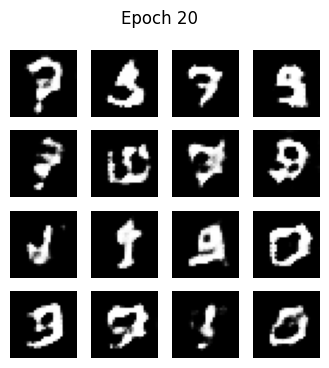

In [7]:
BATCH_SIZE = 256
EPOCHS = 20
seed = tf.random.normal([16, 100])  # for generating sample images

dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(BATCH_SIZE)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch}")
    plt.show()

for epoch in range(1, EPOCHS+1):
    for image_batch in dataset:
        train_step(image_batch)
    generate_and_save_images(generator, epoch, seed)

**Pre - trained model**

In [9]:
!pip install pytorch-lightning lightning-bolts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 59.0 MB/s eta 0:00:00


In [10]:
import torch
from pl_bolts.models.gans import GAN
from pl_bolts.datamodules import MNISTDataModule
from pytorch_lightning import Trainer

# 1. Create a GAN model
# MNIST images are grayscale (1 channel) and 28x28 pixels
model = GAN(input_channels=1, input_height=28, input_width=28)

# 2. Load MNIST dataset (pl_bolts has a ready-made DataModule for it)
datamodule = MNISTDataModule(batch_size=32)

# 3. Create a Trainer
trainer = Trainer(max_epochs=5, accelerator="cpu")
# If you have GPU, use: accelerator="gpu", devices=1

# 4. Train the GAN
trainer.fit(model, datamodule=datamodule)

/usr/local/lib/python3.12/dist-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options"

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


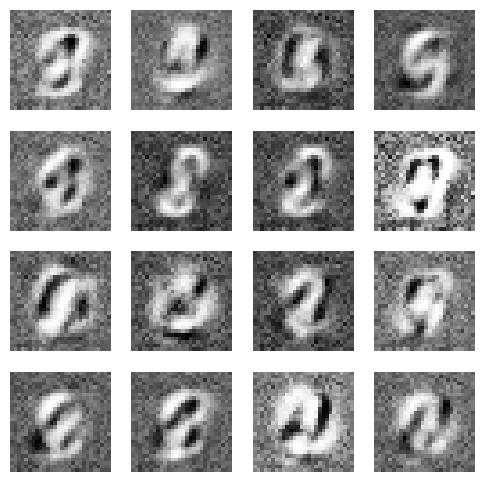

In [11]:
import torch
import matplotlib.pyplot as plt

# Put the generator in evaluation mode
model.generator.eval()

# 1. Generate random noise (e.g., 16 samples of 100-dim noise vectors)
z = torch.randn(16, model.hparams.latent_dim)

# 2. Generate fake images
with torch.no_grad():
    fake_images = model.generator(z)

# 3. Plot them (MNIST images are 28x28 grayscale)
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(fake_images[i].squeeze().cpu().numpy(), cmap="gray")
    ax.axis("off")
plt.show()


In [ ]:
!pip install diffusers transformers accelerate

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    torch_dtype=torch.float16
).to("cuda")

image = pipe("A futuristic city skyline at sunset").images[0]
image.show()


In [12]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "sd-legacy/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
#pipe.enable_model_cpu_offload() #save some VRAM by offloading the model to CPU. Remove this if you have enough GPU power
pipe = pipe.to("cuda")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [13]:
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]

image.save("astronaut_rides_horse.png")

  0%|          | 0/50 [00:00<?, ?it/s]

array([[[224, 198, 169],
        [230, 200, 167],
        [227, 198, 169],
        ...,
        [224, 195, 160],
        [224, 194, 163],
        [223, 198, 166]],

       [[230, 198, 168],
        [229, 199, 171],
        [228, 198, 169],
        ...,
        [224, 195, 163],
        [225, 194, 164],
        [227, 195, 165]],

       [[229, 197, 169],
        [229, 199, 169],
        [227, 198, 166],
        ...,
        [225, 195, 163],
        [224, 195, 163],
        [226, 195, 166]],

       ...,

       [[200, 135,  90],
        [175,  95,  61],
        [183, 109,  72],
        ...,
        [185, 114,  79],
        [192, 118,  80],
        [202, 135,  92]],

       [[191, 126,  87],
        [181, 108,  69],
        [188, 115,  76],
        ...,
        [195, 125,  90],
        [201, 130,  89],
        [191, 125,  81]],

       [[149,  93,  67],
        [162, 100,  64],
        [185, 120,  78],
        ...,
        [187, 134,  93],
        [195, 137,  93],
        [184, 137,  98]]], dtype=uint8)
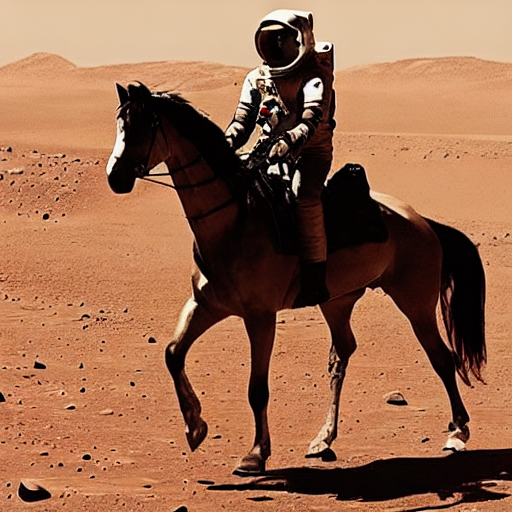

In [17]:
import cv2

image = cv2.imread('/content/astronaut_rides_horse.png')
image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
image

In [19]:
from huggingface_hub import notebook_login
notebook_login()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import torch
from diffusers import FluxPipeline

pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", torch_dtype=torch.bfloat16)
pipe.enable_model_cpu_offload() #save some VRAM by offloading the model to CPU. Remove this if you have enough GPU power

model_index.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

Fetching 23 files:   0%|          | 0/23 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

text_encoder_2/model-00002-of-00002.safe(…):   0%|          | 0.00/4.53G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder_2/model-00001-of-00002.safe(…):   0%|          | 0.00/4.99G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

tokenizer_2/spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/378 [00:00<?, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/9.95G [00:00<?, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/9.98G [00:00<?, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/3.87G [00:00<?, ?B/s]

(…)ion_pytorch_model.safetensors.index.json:   0%|          | 0.00/121k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/820 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

In [ ]:
prompt = "A cat holding a sign that says hello world"
image = pipe(
    prompt,
    height=1024,
    width=1024,
    guidance_scale=3.5,
    num_inference_steps=50,
    max_sequence_length=512,
    generator=torch.Generator("cpu").manual_seed(0)
).images[0]
image.save("flux-dev.png")
